In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

In [2]:
df = pd.read_excel('Dataset KRL 2006-2023.xlsx')
df


,Wilayah,Tanggal,Jumlah,Longitude,Latitude
0,Jabodetabek,2006-01-01,8681,106.8178,-6.2175
1,Jabodetabek,2006-02-01,8144,106.8178,-6.2175
2,Jabodetabek,2006-03-01,8920,106.8178,-6.2175
3,Jabodetabek,2006-04-01,8462,106.8178,-6.2175
4,Jabodetabek,2006-05-01,8899,106.8178,-6.2175
...,...,...,...,...,...
827,Jawa (Jabodetabek+Non Jabodetabek),2023-04-01,27731,110.7122,-7.6145
828,Sumatera,2023-01-01,582,101.3431,-0.5897
829,Sumatera,2023-02-01,515,101.3431,-0.5897
830,Sumatera,2023-03-01,571,101.3431,-0.5897


In [3]:
df.columns

Index(['Wilayah', 'Tanggal', 'Jumlah', 'Longitude', 'Latitude'], dtype='object')

In [4]:
df = df.drop(columns = ['Longitude','Latitude'], axis=1)
df['Tanggal'] = pd.to_datetime(df['Tanggal'])
df

,Wilayah,Tanggal,Jumlah
0,Jabodetabek,2006-01-01,8681
1,Jabodetabek,2006-02-01,8144
2,Jabodetabek,2006-03-01,8920
3,Jabodetabek,2006-04-01,8462
4,Jabodetabek,2006-05-01,8899
...,...,...,...
827,Jawa (Jabodetabek+Non Jabodetabek),2023-04-01,27731
828,Sumatera,2023-01-01,582
829,Sumatera,2023-02-01,515
830,Sumatera,2023-03-01,571


In [5]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Konversi wilayah ke dalam bentuk angka menggunakan Label Encoder
label_encoder = LabelEncoder()
df['Kode Wilayah'] = label_encoder.fit_transform(df['Wilayah'])
# Konversi tanggal menjadi selisih dengan tanggal acuan (2006-01-01)
reference_date = pd.to_datetime('2006-01-01')
df['Tanggal Relatif'] = (df['Tanggal']-reference_date).dt.days

In [6]:
df.head(5)

,Wilayah,Tanggal,Jumlah,Kode Wilayah,Tanggal Relatif
0,Jabodetabek,2006-01-01,8681,0,0
1,Jabodetabek,2006-02-01,8144,0,31
2,Jabodetabek,2006-03-01,8920,0,59
3,Jabodetabek,2006-04-01,8462,0,90
4,Jabodetabek,2006-05-01,8899,0,120


In [7]:
# Pisahkan fitur dan target
X = df[['Kode Wilayah', 'Tanggal Relatif']]
y = df['Jumlah']

# Bagi data menjadi 80% data pelatihan dan 20% data uji
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
A =df['Kode Wilayah'].unique()
A

array([0, 2, 1, 3])

In [9]:
for i in A:
    # Buat nama variabel berdasarkan nilai unik, misal: df_0, df_1, dst.
    globals()[f"df_{i}"] = df[df['Kode Wilayah'] == i]

In [10]:
from sklearn.model_selection import learning_curve

# Plotting line curve
def plot_learning_curve(model, X, y):
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=10, scoring='r2')
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_scores_mean, label='Training Error')
    plt.plot(train_sizes, test_scores_mean, label='Validation Error')
    plt.xlabel('Training Set Size')
    plt.ylabel('r2')
    plt.title('Learning Curve Based on r2')
    plt.legend()
    plt.grid(False)
    plt.show()

In [11]:
from sklearn.ensemble import RandomForestRegressor

# Inisialisasi model Random Forest Regressor
model_2 = RandomForestRegressor(random_state=42)

# Tentukan hyperparameter yang ingin dituning dan daftar nilai-nilai yang akan diuji
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 5, 10, 15, 20, 25, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Inisialisasi GridSearchCV dengan model, hyperparameter yang ingin dituning, dan metrik evaluasi 'r2'
grid_search = GridSearchCV(estimator=model_2, param_grid=param_grid, cv=10, scoring='r2')

# Latih model dengan GridSearchCV
grid_search.fit(X_train, y_train)

# Dapatkan model terbaik setelah tuning
best_model_rf = grid_search.best_estimator_

# Lakukan cross-validation dan peroleh MAE, MSE, dan R2 score di setiap fold
mae_scores_2 = -cross_val_score(best_model_rf, X_train, y_train, cv=10, scoring='neg_mean_absolute_error')
mse_scores_2 = -cross_val_score(best_model_rf, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
r2_scores_2 = cross_val_score(best_model_rf, X_train, y_train, cv=10, scoring='r2')

# Evaluasi model pada data uji
y_pred_2 = best_model_rf.predict(X_test)
mae_test_2 = mean_absolute_error(y_test, y_pred_2)
mse_test_2 = mean_squared_error(y_test, y_pred_2)
r2_test_2 = r2_score(y_test, y_pred_2)

# Tampilkan MAE, MSE, dan R2 score di setiap fold cross-validation
print("MAE Scores (Cross-Validation):", mae_scores_2)
print("MSE Scores (Cross-Validation):", mse_scores_2)
print("R2 Scores (Cross-Validation):", r2_scores_2)

# Tampilkan rata-rata MAE, MSE, dan R2 score dari cross-validation
print("Average MAE (Cross-Validation):", np.mean(mae_scores_2))
print("Average MSE (Cross-Validation):", np.mean(mse_scores_2))
print("Average R2 (Cross-Validation):", np.mean(r2_scores_2))

# Tampilkan MAE, MSE, dan R2 score pada data uji
print("MAE (Test Set):", mae_test_2)
print("MSE (Test Set):", mse_test_2)
print("R2 (Test Set):", r2_test_2)


MAE Scores (Cross-Validation): [523.55669744 585.19817322 521.96316684 709.62264269 574.00050437
 762.79416601 641.98942498 741.2717305  630.60807443 656.14083282]
MSE Scores (Cross-Validation): [ 619223.46123627 1016443.35899316  850829.1128132  1274297.4136822
  662464.1982821  1631484.56260713  870700.26993174 1439947.53841643
 1607917.3914065  1116277.16194151]
R2 Scores (Cross-Validation): [0.9926986  0.98983533 0.99075308 0.98694406 0.99193826 0.98795693
 0.99115443 0.98808136 0.97693976 0.98851225]
Average MAE (Cross-Validation): 634.7145413284401
Average MSE (Cross-Validation): 1108958.4469310245
Average R2 (Cross-Validation): 0.9884814066995731
MAE (Test Set): 632.6587312078715
MSE (Test Set): 978943.8865818991
R2 (Test Set): 0.9893959001128122


In [12]:
df['Prediction Random Forest'] = best_model_rf.predict(X)

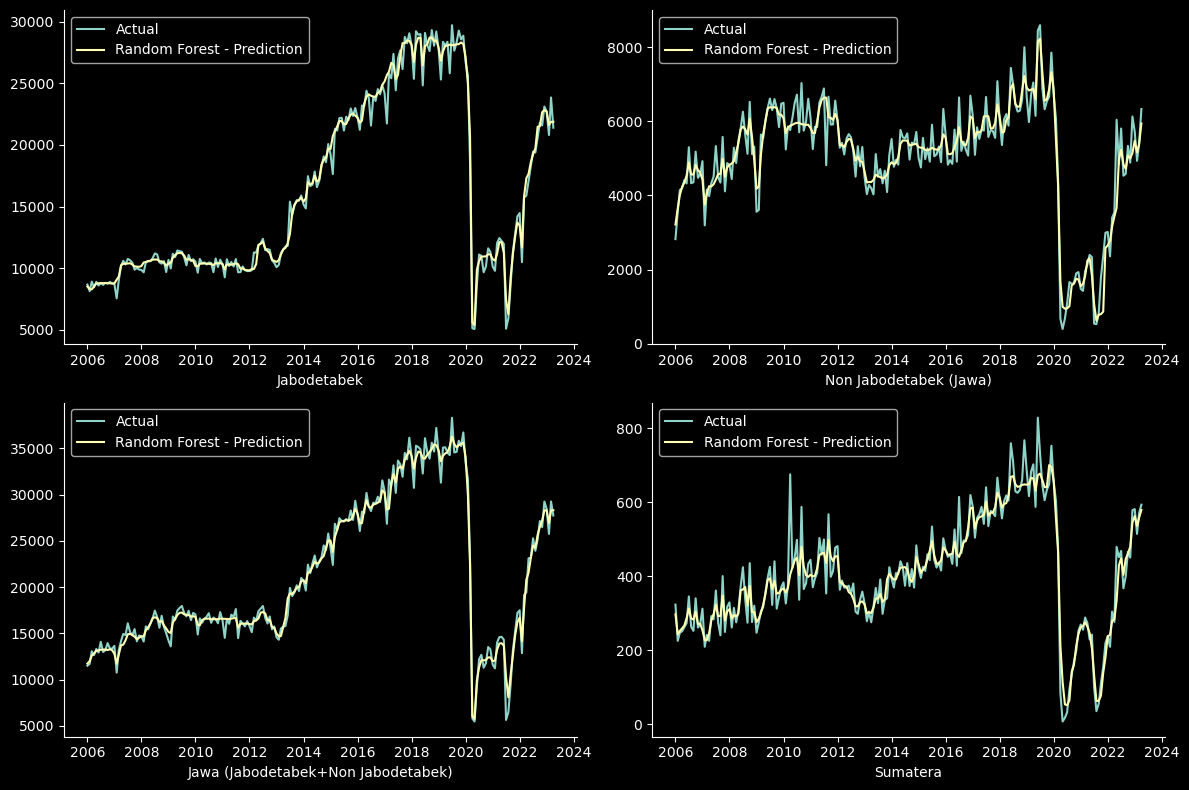

In [13]:
plt.style.use('dark_background')
# Buat subplots dengan 2 baris dan 2 kolom
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Bagi DataFrame menjadi beberapa DataFrame berdasarkan nilai unik dalam 'Kode Wilayah'
for i, ax in zip(A, axes.flatten()):
    df_i = df[df['Kode Wilayah'] == i]
    ax.plot(df_i['Tanggal'], df_i['Jumlah'], label='Actual')
    ax.plot(df_i['Tanggal'], df_i['Prediction Random Forest'], label='Random Forest - Prediction')
    ax.set_xlabel(df_i['Wilayah'].unique()[0])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend()

plt.tight_layout()
plt.show()


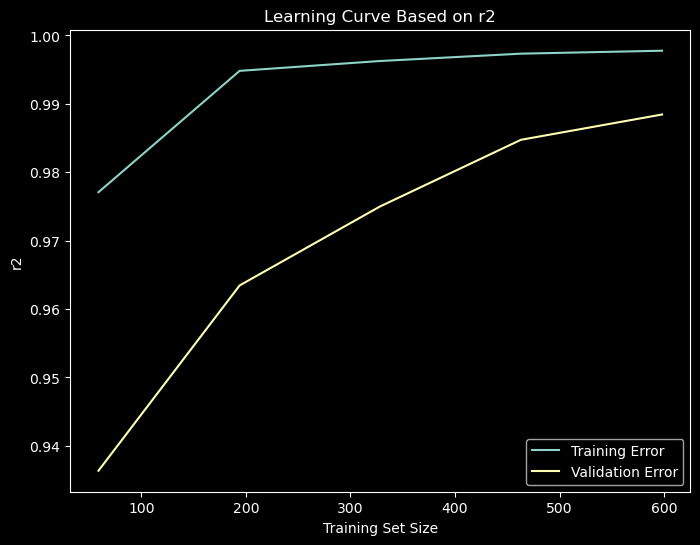

In [18]:
# Tampilkan learning curve untuk best_model_random_forest
plot_learning_curve(best_model_rf, X_train, y_train)

In [14]:
from sklearn.linear_model import LinearRegression

# Inisialisasi model Linear Regression
Linreg = LinearRegression()

# Tentukan hyperparameter yang ingin dituning dan daftar nilai-nilai yang akan diuji
param_grid = {
    'fit_intercept': [True, False]
}

# Inisialisasi GridSearchCV dengan model dan hyperparameter yang ingin dituning
grid_search = GridSearchCV(estimator=Linreg, param_grid=param_grid, cv=10, scoring='r2')

# Latih model dengan GridSearchCV
grid_search.fit(X_train, y_train)

# Dapatkan model terbaik setelah tuning
best_model_linreg = grid_search.best_estimator_

# Lakukan prediksi menggunakan data uji pada model terbaik
y_pred_linreg = best_model_linreg.predict(X_test)

# Evaluasi model
mae_test_linreg = mean_absolute_error(y_test, y_pred_linreg)
mse_test_linreg = mean_squared_error(y_test, y_pred_linreg)
r2_test_linreg = r2_score(y_test, y_pred_linreg)

# Tampilkan MAE, MSE, dan R2 score pada data uji untuk model terbaik
print("Best Model Hyperparameters:", grid_search.best_params_)
print("MAE (Test Set):", mae_test_linreg)
print("MSE (Test Set):", mse_test_linreg)
print("R2 (Test Set):", r2_test_linreg)


Best Model Hyperparameters: {'fit_intercept': True}
MAE (Test Set): 5016.552569585321
MSE (Test Set): 43977350.353510335
R2 (Test Set): 0.5236292679136507


In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# Inisialisasi list untuk menyimpan hasil evaluasi
degrees = np.arange(1, 11)
mae_test_list = []
mse_test_list = []
r2_test_list = []

# Lakukan iterasi untuk setiap degree dan lakukan tuning model
for degree in degrees:
    # Transformasikan fitur menjadi fitur polinomial dengan degree tertentu
    poly = PolynomialFeatures(degree=degree)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)

    # Inisialisasi model Linear Regression
    Linreg = LinearRegression()

    # Buat pipeline untuk memasukkan PolynomialFeatures ke dalam model Linear Regression
    model_poly = make_pipeline(poly, Linreg)

    # Inisialisasi GridSearchCV dengan model dan hyperparameter yang ingin dituning
    param_grid = {}

    grid_search_poly = GridSearchCV(estimator=model_poly, param_grid=param_grid, cv=10, scoring='r2')

    # Latih model dengan GridSearchCV pada fitur-fitur polinomial
    grid_search_poly.fit(X_train, y_train)

    # Dapatkan model terbaik setelah tuning
    best_model_poly = grid_search_poly.best_estimator_

    # Lakukan prediksi menggunakan data uji pada model terbaik
    y_pred_poly = best_model_poly.predict(X_test)

    # Evaluasi model pada data uji
    mae_test_poly = mean_absolute_error(y_test, y_pred_poly)
    mse_test_poly = mean_squared_error(y_test, y_pred_poly)
    r2_test_poly = r2_score(y_test, y_pred_poly)

    # Simpan hasil evaluasi pada list
    mae_test_list.append(mae_test_poly)
    mse_test_list.append(mse_test_poly)
    r2_test_list.append(r2_test_poly)

    # Tampilkan MAE, MSE, dan R2 score pada data uji untuk model terbaik dengan degree tertentu
    print(f"Degree: {degree}")
    print("Best Model Hyperparameters:", grid_search_poly.best_params_)
    print("MAE (Test Set):", mae_test_poly)
    print("MSE (Test Set):", mse_test_poly)
    print("R2 (Test Set):", r2_test_poly)
    print()

# Tampilkan hasil evaluasi untuk setiap degree
print("MAE Test List:", mae_test_list)
print("MSE Test List:", mse_test_list)
print("R2 Test List:", r2_test_list)



Degree: 1
Best Model Hyperparameters: {}
MAE (Test Set): 5016.552569585183
MSE (Test Set): 43977350.353509836
R2 (Test Set): 0.5236292679136562

Degree: 2
Best Model Hyperparameters: {}
MAE (Test Set): 4512.187506851851
MSE (Test Set): 32730983.062393304
R2 (Test Set): 0.6454519829411776

Degree: 3
Best Model Hyperparameters: {}
MAE (Test Set): 3040.506755082218
MSE (Test Set): 16837173.05481149
R2 (Test Set): 0.8176166506187684

Degree: 4
Best Model Hyperparameters: {}
MAE (Test Set): 2659.874467536722
MSE (Test Set): 16366789.77478293
R2 (Test Set): 0.8227119286577397

Degree: 5
Best Model Hyperparameters: {}
MAE (Test Set): 3039.467724089482
MSE (Test Set): 16444892.321528891
R2 (Test Set): 0.8218659075338632

Degree: 6
Best Model Hyperparameters: {}
MAE (Test Set): 3402.4073653526334
MSE (Test Set): 18014435.506521266
R2 (Test Set): 0.8048643276281681

Degree: 7
Best Model Hyperparameters: {}
MAE (Test Set): 5337.51819155587
MSE (Test Set): 44427126.234945975
R2 (Test Set): 0.51875

In [19]:
import pickle
with open('model.pkl', 'wb') as f:
    pickle.dump(best_model_rf, f)

In [20]:
df

,Wilayah,Tanggal,Jumlah,Kode Wilayah,Tanggal Relatif,Prediction Random Forest
0,Jabodetabek,2006-01-01,8681,0,0,8525.326667
1,Jabodetabek,2006-02-01,8144,0,31,8321.266667
2,Jabodetabek,2006-03-01,8920,0,59,8290.606667
3,Jabodetabek,2006-04-01,8462,0,90,8530.506667
4,Jabodetabek,2006-05-01,8899,0,120,8766.693333
...,...,...,...,...,...,...
827,Jawa (Jabodetabek+Non Jabodetabek),2023-04-01,27731,1,6299,28300.486667
828,Sumatera,2023-01-01,582,3,6209,563.480000
829,Sumatera,2023-02-01,515,3,6240,536.533333
830,Sumatera,2023-03-01,571,3,6268,558.560000


In [21]:
df['Wilayah'].unique()

array(['Jabodetabek', 'Non Jabodetabek (Jawa)',
       'Jawa (Jabodetabek+Non Jabodetabek)', 'Sumatera'], dtype=object)

In [31]:
import sklearn
print(sklearn.__version__)


1.2.2
